# Titanic Kaggle Submission - Predicting Survival on the Titanic

In this notebook, I conduct some preprocessing on the Train and Test sets of the Kaggle titanic datasets. 

I then use a couple different classification techniques -K Nearest Neighbors and a Random Forest Decision Tree - to classify whether a passenger will live or die on the Titanic. I did a train-test split on the train dataset. 

For the KNN, I used Grid Search and a Pipeline in which I imputed null values and scaled the data. KNN was my best model, with an accuracy score of .83 on the holdout set. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer, Imputer
from sklearn.pipeline import Pipeline
%matplotlib inline

In [2]:
train = pd.read_csv('./train.csv')

In [3]:
test = pd.read_csv('./test.csv')

## Exploratory Analysis and Cleaning

In this section, I created a Family Count feature as the sum of Siblings+Spouse and Parents+Children variables. I also dummy code Sex, Passenger Class, and Port of Embarkation. I do this for both the train and the test datasets. 

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train['FamilyCount'] = train['SibSp'] + train['Parch']

It is my practice to preserve original variables before dummy-coding, just in case I need the originals for other analysis. So, I create duplicates before dummy-coding. 

In [6]:
train['Embarked2'] = train['Embarked']
train['Sex2'] = train['Sex']
train['Pclass2'] = train['Pclass']

In [7]:
train = pd.get_dummies(train, columns = ["Embarked2", "Sex2", "Pclass2"])

Here, I see that the dummy-coded variables were created successfully. 

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,FamilyCount,Embarked2_C,Embarked2_Q,Embarked2_S,Sex2_female,Sex2_male,Pclass2_1,Pclass2_2,Pclass2_3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,1,0,0,1,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,1,1,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,0,0,0,1,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,1,0,0,1,1,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,0,0,0,1,0,1,0,0,1


In [9]:
test['FamilyCount'] = test['SibSp'] + test['Parch']

In [10]:
test['Embarked2'] = test['Embarked']
test['Sex2'] = test['Sex']
test['Pclass2'] = test['Pclass']

In [11]:
test = pd.get_dummies(test, columns = ["Embarked2", "Sex2", "Pclass2"])

In [12]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount,Embarked2_C,Embarked2_Q,Embarked2_S,Sex2_female,Sex2_male,Pclass2_1,Pclass2_2,Pclass2_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2,0,0,1,1,0,0,0,1


### Heatmap of all variables in the Train set. 
This heatmap shows the correlations between all variables. We see that Female, Passenger Class 3, and Age correlate strongly with Survival. 

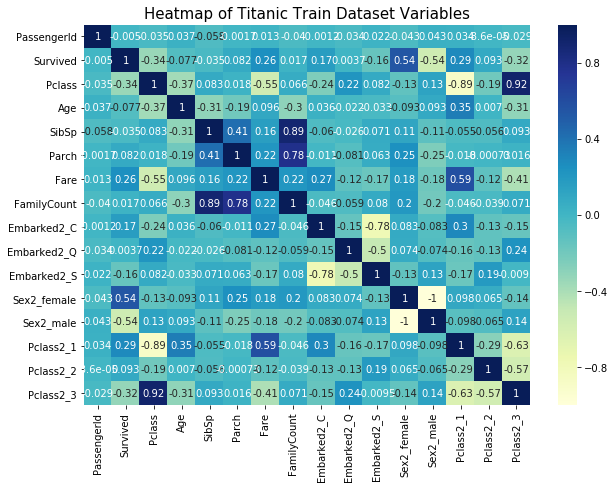

In [13]:
plt.figure(figsize=(10, 7))
sns.heatmap(train.corr(), annot=True,cmap="YlGnBu")
plt.title('Heatmap of Titanic Train Dataset Variables', fontsize=15)
plt.savefig('Heatmap.png')

In [14]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
FamilyCount      0
Embarked2_C      0
Embarked2_Q      0
Embarked2_S      0
Sex2_female      0
Sex2_male        0
Pclass2_1        0
Pclass2_2        0
Pclass2_3        0
dtype: int64

While I can use the Imputer in the pipeline to impute null values in the Train set, I don't believe I can do so for the Test set, so I will impute the values for Age and Fare here. 

In [15]:
test['Fare'].fillna((test['Fare'].mean()), inplace=True)

In [16]:
test['Age'].fillna((test['Age'].mean()), inplace=True)

In [17]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilyCount      0
Embarked2_C      0
Embarked2_Q      0
Embarked2_S      0
Sex2_female      0
Sex2_male        0
Pclass2_1        0
Pclass2_2        0
Pclass2_3        0
dtype: int64

## KNN Classification with Grid Search and a Pipeline

In [18]:
features = ['FamilyCount', 'Embarked2_C', 'Embarked2_Q','Embarked2_S','Sex2_female','Sex2_male',
'Pclass2_1','Pclass2_2','Pclass2_3', 'Age', 'Fare']
X = train[features]
y = train['Survived']

In [19]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state = 42)

### Baseline model: 38% survival rate

In [20]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [21]:
imputer = Imputer()

ss = StandardScaler()

knn = KNeighborsClassifier()

pipe = Pipeline([
    ('imputer', imputer),
    ('ss', ss),
    ('knn', knn)
])

In [22]:
params = {
    'knn__n_neighbors': range(1,21), #search through 1 to 20 neighbors
    'knn__p': [1,2], #try both euclidean and manhattan distance
    'imputer__strategy': ['mean', 'median', 'most_frequent'] #instead of using mean, use these
}
gs = GridSearchCV(pipe, param_grid=params)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.811377245508982


{'imputer__strategy': 'most_frequent', 'knn__n_neighbors': 3, 'knn__p': 1}

### Model accuracy score is 83%, which is above baseline. Nice! 

In [23]:
gs.score(X_holdout, y_holdout)

0.8295964125560538

### Making predictions in the test dataset

My submission scored .68899 and ranked 9540. 

In [24]:
X_test = test[features]
X_test_scaled = ss.fit_transform(X_test)
X_test_scaled

array([[-0.5534426 , -0.56814154,  2.84375747, ...,  0.95782629,
         0.3349926 , -0.49840706],
       [ 0.10564289, -0.56814154, -0.35164743, ...,  0.95782629,
         1.32553003, -0.51327429],
       [-0.5534426 , -0.56814154,  2.84375747, ..., -1.04403065,
         2.51417495, -0.46508846],
       ...,
       [-0.5534426 , -0.56814154, -0.35164743, ...,  0.95782629,
         0.65196458, -0.50879189],
       [-0.5534426 , -0.56814154, -0.35164743, ...,  0.95782629,
         0.        , -0.4944482 ],
       [ 0.76472838,  1.76012477, -0.35164743, ...,  0.95782629,
         0.        , -0.23790598]])

In [25]:
predictions = gs.predict(X_test_scaled)

In [26]:
test['Survived'] = predictions

In [27]:
test[['PassengerId', 'Survived']].to_csv('titanic_kaggle_submission.csv', index=False)

## Random Forest Classification

This model gave me a lower accuracy score, .789, so I did not submit it to Kaggle. 

In [28]:
train['Fare'].fillna((train['Fare'].mean()), inplace=True)

In [29]:
train['Age'].fillna((train['Age'].mean()), inplace=True)

In [30]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilyCount      0
Embarked2_C      0
Embarked2_Q      0
Embarked2_S      0
Sex2_female      0
Sex2_male        0
Pclass2_1        0
Pclass2_2        0
Pclass2_3        0
dtype: int64

In [35]:
features2 = ['FamilyCount', 'Embarked2_C', 'Embarked2_Q','Embarked2_S','Sex2_female','Sex2_male',
'Pclass2_1','Pclass2_2','Pclass2_3', 'Age', 'Fare']
X2 = train[features]
y2 = train['Survived']

In [36]:
X2_train, X2_holdout, y2_train, y2_holdout = train_test_split(X2, y2, random_state = 42)

In [37]:
X2_train_scaled = ss.fit_transform(X2_train)
X2_holdout_scaled = ss.transform(X2_holdout)

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
rf_params ={
    'n_estimators': [5, 10, 15, 20, 25],
    'max_depth': [None, 1, 2, 3],
    'max_features': ['auto', 'log2'],
}
gs_rf = GridSearchCV(rf, rf_params)
gs_rf.fit(X2_train, y2_train)
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.8083832335329342
{'max_depth': None, 'max_features': 'auto', 'n_estimators': 15}


In [39]:
gs_rf.score(X2_holdout, y2_holdout)

0.7892376681614349

These are the feature importances used by the Random Forest Model.  Fare, Age, and Sex were the most important features. 

In [40]:
rf_best = gs_rf.best_estimator_
best_features = rf_best.feature_importances_
pd.DataFrame(best_features)

fi = pd.DataFrame({
        'feature':X.columns,
        'importance':rf_best.feature_importances_
    })

fi.sort_values('importance', ascending=False, inplace=True)
fi

,feature,importance
10,Fare,0.265455
9,Age,0.251999
4,Sex2_female,0.171653
5,Sex2_male,0.113133
0,FamilyCount,0.074331
8,Pclass2_3,0.057259
6,Pclass2_1,0.022930
3,Embarked2_S,0.015925
1,Embarked2_C,0.011778
2,Embarked2_Q,0.009969


Here, I save the cleaned training file as a .csv to use for data visualization.

In [42]:
train.to_csv('titanic_for_viz.csv', index=False)